In [1]:
import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

Base tarafından gerçekleştirilen özellik çıkarımı 3 temel işlemden oluşur:<br>
    1. Belirli bir özellik için bir görüntüyü filtreleme (convolution) -> Filter<br>
    2. Filtrelenmiş görüntüdeki bu özelliği algıla (ReLU) -> Detect<br>
    3. Özellikleri geliştirmek için görüntüyü sıkıştır -> Condense(maximum pooling)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = (
    layers.Conv2D(filters=64, kernel_size=3) # activation is none
    # More layers follow
)

# Weights
Bir convnet'in eğitim sırasında öğrendiği ağırlıklar, öncelikle evrişimsel katmanlarında bulunur. Bu ağırlıklara çekirdek(kernel) diyoruz.Bunları küçük diziler olarak gösterebiliriz.<br><br>
Çekirdek bir evrişimli katmanın izleyen katmana nasıl bağlanacağını tanımlar. Örneğin çıktıdaki her bir nöronu girdideki dokuz nörona bağlar.

# Activations
Özellik haritaları denilen ağdaki aktivasyonlardır. Bir görüntüye filtre uyguladığımızda ortaya çıkan sonuçlardır. Çekirdeğin çıkardığı görsel özellikleri içerir.<br><br>
Genel olarak, bir konvolüsyonun girdilerinde vurguladığı şey, çekirdekteki pozitif sayıların şekliyle eşleşecektir.<br>
*filters* parametresiyle, evrişim katmanına çıktı olarak kaç tane özellik haritası oluşturmasını istediğinizi söylersiniz.

# Detect with ReLU
Filtrelemeden sonra özellik haritaları(feature maps) aktivasyon fonksiyonundan geçer.<br>
ReLU aktivasyonu kendi Aktivasyon katmanında tanımlanabilir. Ancak çoğu zaman bunu Conv2D'nin aktivasyon kodu olarak dahil ederiz.

In [5]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
])

Aktivasyon fonksiyonu, bazı önem ölçülerine göre piksel değerlerinin puanlaması olarak düşünülebilir.<br><br>
ReLU aktivasyonu, negatif değerlerin önemli olmadığını söyler ve bu nedenle onları 0'a eşitler. (Önemsiz olan her şey eşit derecede önemsizdir.)<br><br>
Diğer aktivasyon fonksiyonları gibi ReLU fonksiyonu da doğrusal değildir.(nonlinear). Doğrusal olmama, özelliklerin ağın daha derinliklerine indikçe ilginç şekillerde bir araya gelmesini sağlar.

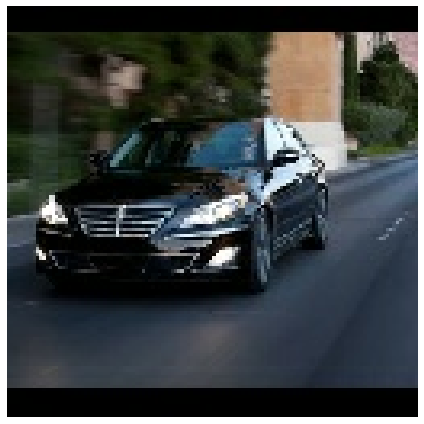

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = 'datas/car.jpeg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image) # jpeg kodlu bir görüntünün kodunu bir unit8 tensörü olarak çözer.

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray') # imshow(imageshow) verileri görüntü olarak gösterir. squeeze fonksiyonu dizideki 1 boyutlarını(yani 1'leri) kaldırıyor(siliyor).
plt.axis('off')  # eksenlerdeki sayıların gösterilmesini engelliyor
# plt.axis('on') # bu şekilde eksenlerde sayılar gözükür
plt.show();

Filtreleme adımı için bir çekirdek tanımlayacağız ve onu evrişim ile uygulayacağız. Çekirdek bir kenar algılama çekirdeğidir.<br>
Sayıların toplamını 0 ile 1 arasında tuutmaya çalışın. (0 ile 1 dahil)

(3, 3)


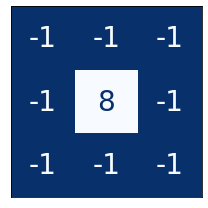

In [6]:
# kernel tanımlama

import tensorflow as tf

kernel = tf.constant([ # tf.constant tensorflow'un kullandığı türden bir tensör oluşturur.
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)
print(kernel.shape)

tf.nn modülünde sinir ağları tarafından gerçekleştirilen birçok yaygın işlem vardır. Bizim kullanacaklarımız conv2d ve relu. Bunlar keras katmanlarının basit işlev sürümleridir.

In [9]:
# Tensorflow ile uyumlu hale getirmek için yeniden biçimlendirme yapıyoruz. (Özellik çıkarmanın ilk adımı)

image = tf.image.convert_image_dtype(image, dtype=tf.float32) # görüntüyü dtype'a çevirme
image = tf.expand_dims(image, axis=0) # tek satırdan oluşan tensör döndürür.
kernel = tf.reshape(kernel, [1, 1, kernel.shape[0], kernel.shape[1]]) # tensörü yeniden boyutlandırma
print(kernel)
kernel = tf.cast(kernel, dtype=tf.float32) # yeni bir tipe tensör atar.

tf.Tensor(
[[[[-1 -1 -1]
   [-1  8 -1]
   [-1 -1 -1]]]], shape=(1, 1, 3, 3), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


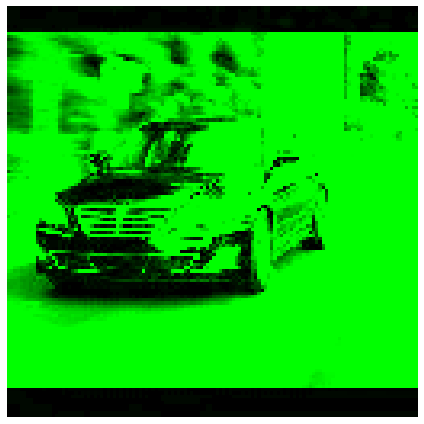

In [10]:
# çekirdek uyguluyoruz (bir evrişimle görüntüye çekirdek uyguluyoruz.)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # The sliding window dosyasında mevcut
    strides=1,
    padding='SAME',
    data_format='NHWC',
    dilations=None,
    name=None
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

- ReLU fonksiyonuyla algılama adımı

Bu fonksiyon, ayarlanacak bir parametre olamdığından evrişimden daha basittir.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


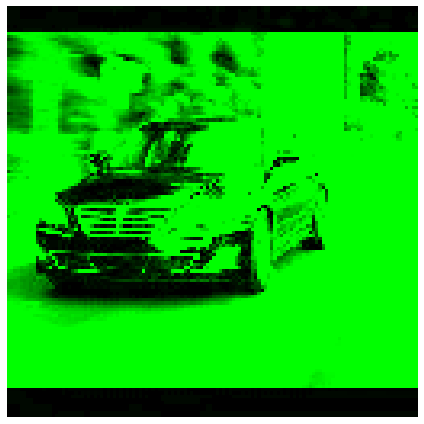

In [48]:
# ReLU uyguluyoruz

image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show()

☺ Uzun lafın kısası: ☺
* Conv2D katmanlarıyla filtrele
* ReLU aktivasyonuyla algıla